# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
# Import the class
from xopt import Xopt

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

In [2]:
!mkdir -p temp

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """
xopt:
  asynch: True
  max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt 
________________________________           
Version: 0.5.0+179.g1221dc6.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {extra_option: abc, sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [4]:
%%timeit
# Check that the averate time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = 1)

The slowest run took 17.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1 s ± 667 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%time
X.run()

CPU times: user 11.2 s, sys: 371 ms, total: 11.5 s
Wall time: 2min 2s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = 10
    X.run()
    
len(X.data)

CPU times: user 3.47 s, sys: 247 ms, total: 3.72 s
Wall time: 13.1 s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time

X = Xopt(YAML)

with ThreadPoolExecutor() as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = 10
    X.run()
len(X.data)

CPU times: user 3.5 s, sys: 147 ms, total: 3.64 s
Wall time: 11.8 s


1001

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.yaml('test.yaml')
!cat test.yaml

xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {extra_option: abc, sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  linked_variables: {x9: x1}


In [11]:
%%time
!mpirun -n 10 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2)
Parallel execution with 10 workers
Initializing Xopt object
Initializing generator cnsga,
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2
Initializing Xopt object
Xopt object initialized
Enabling async mode

            Xopt 
________________________________           
Version: 0.5.0+179.g1221dc6.dirty
Data size: 0
Config as YAML:
xopt: {asynch: true, strict: false, dump_file: null, max_evaluations: 1000}
generator: {name: cnsga, population_size: 64, crossover_probability: 0.9, mutation_probability: 1.0,
  population_file: null, output_path: temp}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {extra_option: abc, sleep: 0, random_sleep: 0.1, raise_probability: 0}
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {

In [12]:
!tail xopt.log

2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Running Xopt step
2022-06-29T14:11:59-0700 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

/Users/chrisonian/Code/mambaforge/envs/xopt-dev/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61339 instead
  warnings.warn(
2022-06-29 14:12:00,914 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-4aalnz6u', purging
2022-06-29 14:12:00,914 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-__p_6us2', purging
2022-06-29 14:12:00,914 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-0qlm_h5i', purging
2022-06-29 14:12:00,914 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/chrisonian/Code/GitHub/Xopt/examples/basic/dask-worker-space/worker-oa89tmao', purgin

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61339/status,
Dashboard: http://127.0.0.1:61339/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61343,Workers: 5
Dashboard: http://127.0.0.1:61339/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:61401,Total threads: 2
Dashboard: http://127.0.0.1:61407/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:61346,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = 10
X.run()

CPU times: user 3.96 s, sys: 604 ms, total: 4.57 s
Wall time: 13.1 s


# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
6,1.162065,1.276658,dummy_constant,1.162065,1.162065,1.276658,1.907168,1.041528,"[1, 2, 3]",False,
5,0.798075,2.779870,dummy_constant,0.798075,0.798075,2.779870,7.388296,5.286655,"[1, 2, 3]",False,
2,2.927502,2.715920,dummy_constant,2.927502,2.927502,2.715920,14.863929,10.803065,"[1, 2, 3]",False,
7,0.723487,0.346437,dummy_constant,0.723487,0.723487,0.346437,-0.421634,0.073528,"[1, 2, 3]",False,
10,2.290614,2.230303,dummy_constant,2.290614,2.290614,2.230303,9.123432,6.200246,"[1, 2, 3]",False,
...,...,...,...,...,...,...,...,...,...,...,...
991,1.099599,0.303972,dummy_constant,NaN,1.099599,0.303972,0.340195,0.397946,"[1, 2, 3]",False,
992,0.430629,0.751239,dummy_constant,NaN,0.430629,0.751239,-0.204553,0.067934,"[1, 2, 3]",False,
997,0.967737,0.137191,dummy_constant,NaN,0.967737,0.137191,0.018405,0.350409,"[1, 2, 3]",False,
996,0.498209,1.097730,dummy_constant,NaN,0.498209,1.097730,0.367129,0.357284,"[1, 2, 3]",False,


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,x9,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str,feasible_c1,feasible_c2,feasible
29,1.149938,0.581789,dummy_constant,1.149938,1.149938,0.581789,0.625620,0.429109,"[1, 2, 3]",False,,True,True,True
27,1.108558,0.755162,dummy_constant,1.108558,1.108558,0.755162,0.898145,0.435450,"[1, 2, 3]",False,,True,True,True
30,0.435587,0.976580,dummy_constant,0.435587,0.435587,0.976580,0.052531,0.231277,"[1, 2, 3]",False,,True,True,True
50,0.997133,0.180009,dummy_constant,0.997133,0.997133,0.180009,0.122673,0.349535,"[1, 2, 3]",False,,True,True,True
65,0.559211,0.982316,dummy_constant,0.559211,0.559211,0.982316,0.319020,0.236134,"[1, 2, 3]",False,,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0.982802,0.153700,dummy_constant,NaN,0.982802,0.153700,0.068554,0.353021,"[1, 2, 3]",False,,True,True,True
991,1.099599,0.303972,dummy_constant,NaN,1.099599,0.303972,0.340195,0.397946,"[1, 2, 3]",False,,True,True,True
997,0.967737,0.137191,dummy_constant,NaN,0.967737,0.137191,0.018405,0.350409,"[1, 2, 3]",False,,True,True,True
996,0.498209,1.097730,dummy_constant,NaN,0.498209,1.097730,0.367129,0.357284,"[1, 2, 3]",False,,True,True,True


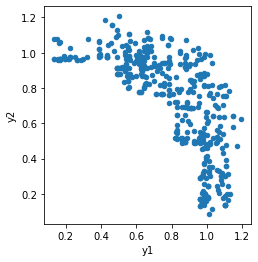

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

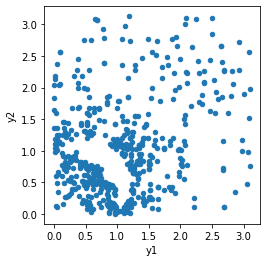

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

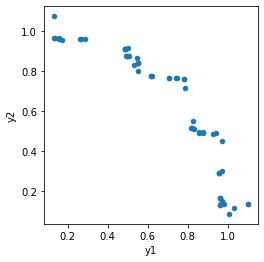

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

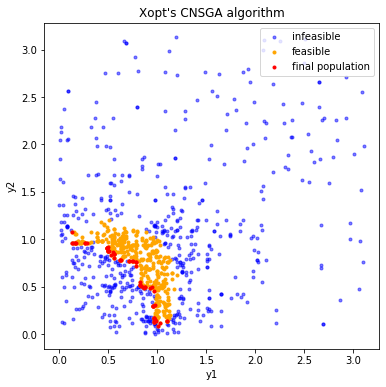

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml